## This notebook is about building a sequence to sequence encoder + decoder to translate midical sentence in english to arabic to be simpler to read

### you'll find every necessary step to train the model and to run inferences ,each line of code has explanation above

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

#### files are .xlsx so this code converts thel to .csv for easier manipulation and processing and save them in the kaggle working directory

In [1]:
import os
import pandas as pd

directory = "/kaggle/input/patient-educaitonal-materials"
output_dir = "/kaggle/working/csv_files"
os.makedirs(output_dir, exist_ok=True)

for file in os.listdir(directory):
    if file.endswith(".xlsx") or file.endswith(".xls"):
        file_path = os.path.join(directory, file)
        
        # Load excel
        df = pd.read_excel(file_path, header=None)
        df.columns = ["disease_english", "disease_arabic"]
        
        # Save as CSV
        csv_file = os.path.splitext(file)[0] + ".csv"
        df.to_csv(os.path.join(output_dir, csv_file), index=False, encoding="utf-8")
        
        


#### read each .csv file that has sentences and their translation so split each file to line "\n" and then split each line with "," then store the english sentence in disease_eng and the arabic one in disease_arab

In [2]:
disease_arabic  =[]
disease_english = []
k = 0
import os
directory = "/kaggle/working/csv_files"

for file in os.listdir(directory):
    file_path = os.path.join(directory , file)
    with open(file_path , "r") as f:
        next(f)
        lines = f.read()
        lines = lines.split("\n")
        k += len(lines)
    for line in lines:
        if len(line.split(",")) != 2:
            continue
        disease_eng , disease_ara = line.split(",")
        disease_arab = "<start> "+ disease_ara + " <end>"
        disease_english.append(disease_eng)
        disease_arabic.append(disease_arab)
    # df = pd.read_csv(file_path , sep="\t")
    # print(df)
    

#### read the 2nd line small test

In [4]:
disease_arabic[1]

'<start> كما يمكن أيضًا إجراء فحص للثديين. <end>'

#### check the length it's necessary the size should be the same

In [5]:

print(len(disease_arabic) , len(disease_english))

10096 10096


In [6]:
str(print(disease_english[3]))

This exam is done to check your:


'None'

#### convert the all the words to lower case for better performance and remove speacial caracters kepp only the raw sentence for bith arabic and english

In [7]:
import re

def clean(disease_english, disease_arabic):
    for i, (sentence_eng, sentence_arab) in enumerate(zip(disease_english, disease_arabic)):
        # clean English: keep only lowercase a-z, replace others with space
        cleaned_eng = re.sub(r"[^a-z]", " ", sentence_eng.lower())
        cleaned_eng = re.sub(r"\s+", " ", cleaned_eng).strip()
        disease_english[i] = cleaned_eng
        
        # clean Arabic: keep Arabic letters + spaces (optional)
        cleaned_arab = re.sub(r"[^\u0600-\u06FF\s]", " ", sentence_arab)
        cleaned_arab = re.sub(r"\s+", " ", cleaned_arab).strip()
        disease_arabic[i] = cleaned_arab

    return disease_english, disease_arabic

disease_english , disease_arabic = clean(disease_english, disease_arabic)

In [8]:
disease_arabic[3]

'يجري هذا الفحص للكشف على'

تم إدخال أنبوب أو قثطار عبر عضلات البطن، حيث يوضع أحد الطرفين في الحيز البريتوني، والحيز البريتوني هو المساحة الفارغة التي تحيط بأعضاء البطن

In [9]:
disease_arabic[1010]

'بعد الاختبار'

In [10]:
disease_english[1010]

'after the test'

#### the "start" and "end" to arabic sentences for the decoder  

In [11]:
def add_start_end(disease_arabic):
    new_sentences = []
    for sentence in disease_arabic:
        sentence_arab = "<start> " + sentence.strip() + " <end>"
        new_sentences.append(sentence_arab)
    return new_sentences

# apply it
disease_arabic = add_start_end(disease_arabic)


In [12]:
disease_arabic[1]

'<start> كما يمكن أيضًا إجراء فحص للثديين <end>'

#### tokenize the english words each word is attributed to an index for later important use

In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(disease_english)
words_vocab = len(tokenizer.word_index) + 1
print(words_vocab)

2025-09-10 17:37:37.463271: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757525857.647333      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757525857.698098      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


4476


#### tokenize the arabic words

In [14]:
tokenizer_arabic = Tokenizer()
tokenizer_arabic.fit_on_texts(disease_arabic)
words_vocab_words = len(tokenizer_arabic.word_index) + 1


#### number of arabic unique words in the dataset

In [15]:
words_vocab_words

11412

#### getting the length of the larget sentence in both arabic and english , it will be used for padding

In [16]:
max_len_eng = max([len(sentence) for sentence in disease_english])
max_len_ara = max([len(sentence) for sentence in disease_arabic])
print(max_len_eng)
print(max_len_ara)

241
219


In [17]:
disease_english[301]

'let go of the pinch of skin'

#### now we apply the tokenization in the first we fitted the tokenizer now we apply it asign each word to an index 

In [18]:
disease_english_tokenized = tokenizer.texts_to_sequences(disease_english)

In [19]:
type(disease_english_tokenized)

list

In [20]:
disease_english_tokenized[1]

[6, 158, 398, 15, 115, 18, 125]

In [21]:
disease_english[1]

'a breast exam may also be done'

#### same here apply tokenization to arabic words

In [22]:
disease_arabic_tokenized = tokenizer_arabic.texts_to_sequences(disease_arabic)

In [23]:
print(disease_arabic_tokenized[1] , disease_arabic[1])

[1, 105, 40, 232, 46, 91, 5910, 2] <start> كما يمكن أيضًا إجراء فحص للثديين <end>


In [24]:
print(disease_arabic_tokenized[2] , disease_arabic[2])

[1, 91, 595, 3117, 2] <start> فحص الحوض للإناث <end>


#### padd every arabic and english sentence to the max length of arabic and english beacause the inout shoukd be the same size in all of them

In [25]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def padding_tokenized_sentences(disease_english_tokenized , disease_arabic_tokenized):
    for i , (sentence_english , sentence_arab) in enumerate(zip(disease_english_tokenized , disease_arabic_tokenized)):
        sentence_e= pad_sequences([sentence_english] , maxlen=max_len_eng , padding="post")[0]
        sentence_a=pad_sequences([sentence_arab] , maxlen=max_len_ara, padding="post")[0]
        disease_english_tokenized[i] = sentence_e
        disease_arabic_tokenized[i] = sentence_a
    return disease_english_tokenized , disease_arabic_tokenized

disease_english_tokenized , disease_arabic_tokenized = padding_tokenized_sentences(disease_english_tokenized , disease_arabic_tokenized)

In [26]:
eng_length= len(disease_english_tokenized[1])
arab_length = len(disease_arabic_tokenized[1])
print(eng_length , arab_length)

241 219


#### convert the english diseases and arabic diseases arrays to numpy array

In [27]:
disease_english_tokenized = np.array(disease_english_tokenized)
disease_arabic_tokenized = np.array(disease_arabic_tokenized)

In [28]:
disease_english_tokenized.shape

(10096, 241)

#### import the necessary layers to build the  training model 

In [29]:
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

#### set the inout shape to max lenght of the english sentence then connvert the inputs to embeddings for semantic meanings much better than one hot encoding (heavy on memero and doesn't code the semantic meanings of the words) then feed the embeddings to the LSTM word by word and save the last hidden and cell state both they summarize the content fo the whole sentence

#### on the decoder the shape of the input is the size of the longest arabic sentence and embedd the word "start" then feed it to the lstm with the hidden and cell state from the encoder then compute the output word and the new hidden and cell state , keep doing this till "end"

#### the last layer is a dense layer to the output of the decoder LSTM is fed to a dense netword in order to make a prediciton of the predicted word using a softmax

I0000 00:00:1757525870.759888      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1757525870.760607      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


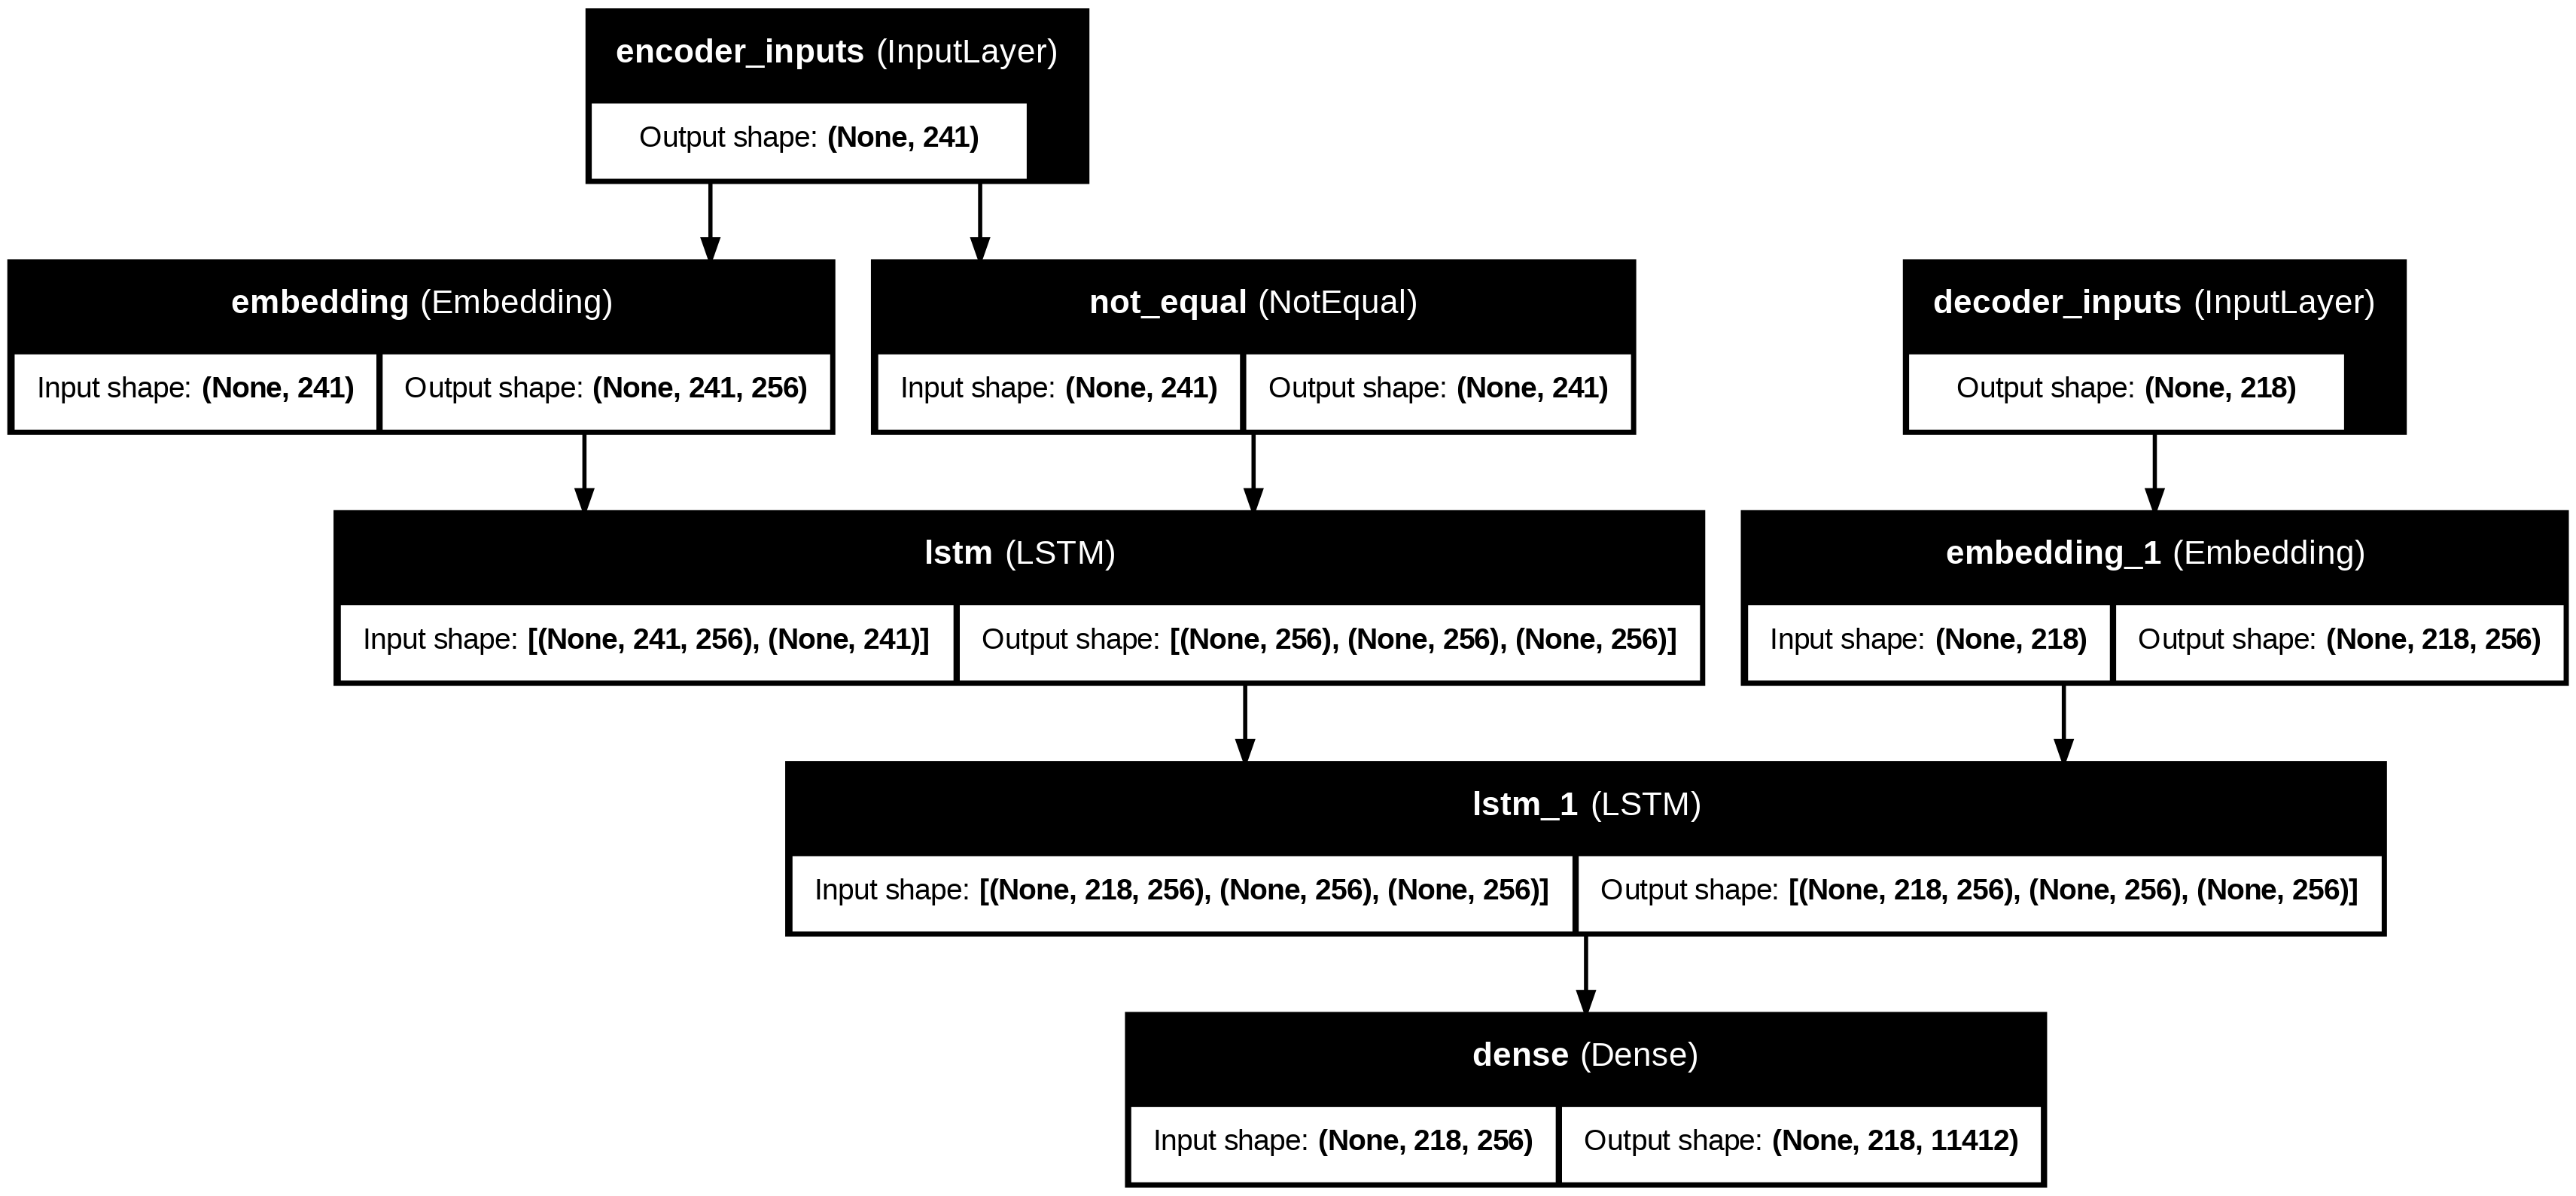

In [30]:
latent_dim = 256

# -------- Encoder --------
encoder_inputs = Input(shape=(eng_length,), name="encoder_inputs")
encoder_emb = Embedding(input_dim=words_vocab, output_dim=latent_dim, mask_zero=True)(encoder_inputs)
enc_outputs, state_h, state_c = LSTM(latent_dim, return_state=True)(encoder_emb)
encoder_states = [state_h, state_c]

# -------- Decoder --------
decoder_inputs = Input(shape=(218,), name="decoder_inputs")
decoder_emb_layer = Embedding(input_dim=words_vocab_words, output_dim=latent_dim, mask_zero=True)
decoder_emb = decoder_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_emb, initial_state=encoder_states)  # fixed typo: 'inital_state' → 'initial_state'

# -------- Decoder dense --------
decoder_dense = Dense(words_vocab_words, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

# -------- Define Model --------
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")


# Optional: visualize the model
plot_model(model, show_shapes=True, show_layer_names=True)


#### split the 2 arrays disease_english and arabic_disease to training and testing data

In [31]:
from sklearn.model_selection import train_test_split
x_train , x_test , y_train , y_test = train_test_split(disease_english_tokenized , disease_arabic_tokenized , test_size=0.2)


In [32]:
len(disease_english_tokenized)

10096

In [33]:
len(disease_english_tokenized[1])

241

In [34]:
len(disease_arabic_tokenized)

10096

#### that's why we added "start" and "end" the input is always "start arabic_words" this is the truth to make teacher forcing (decoder_input_train) then after prediciton we compare the result that looks like "arabic_words end" to the ground truth (decoder_target_train)  and same for testing

In [35]:
decoder_input_train  = y_train[:, :-1]   # remove last token (<end>)
decoder_target_train = y_train[:, 1:]    # remove first token (<start>)

decoder_input_test  = y_test[:, :-1]
decoder_target_test = y_test[:, 1:]


In [36]:
print(len(decoder_input_train[0]) , len(decoder_target_train[0]))

218 218


In [37]:
len(disease_arabic_tokenized[1])

219

### model training 

In [38]:
model.fit(
    [x_train, decoder_input_train],   # encoder input + shifted decoder input
    decoder_target_train,             # shifted decoder target
    batch_size=64,
    epochs=60,
    validation_split=0.1
)


Epoch 1/60


I0000 00:00:1757525877.426309     101 cuda_dnn.cc:529] Loaded cuDNN version 90300


114/114 ━━━━━━━━━━━━━━━━━━━━ 21s 141ms/step - loss: 7.7920 - val_loss: 6.3749
Epoch 2/60
114/114 ━━━━━━━━━━━━━━━━━━━━ 16s 138ms/step - loss: 6.0747 - val_loss: 6.2516
Epoch 3/60
114/114 ━━━━━━━━━━━━━━━━━━━━ 16s 140ms/step - loss: 5.8056 - val_loss: 6.1846
Epoch 4/60
114/114 ━━━━━━━━━━━━━━━━━━━━ 16s 142ms/step - loss: 5.5790 - val_loss: 6.0617
Epoch 5/60
114/114 ━━━━━━━━━━━━━━━━━━━━ 16s 144ms/step - loss: 5.3665 - val_loss: 5.9371
Epoch 6/60
114/114 ━━━━━━━━━━━━━━━━━━━━ 17s 146ms/step - loss: 5.1323 - val_loss: 5.8193
Epoch 7/60
114/114 ━━━━━━━━━━━━━━━━━━━━ 17s 149ms/step - loss: 4.8444 - val_loss: 5.7170
Epoch 8/60
114/114 ━━━━━━━━━━━━━━━━━━━━ 17s 149ms/step - loss: 4.6070 - val_loss: 5.6730
Epoch 9/60
114/114 ━━━━━━━━━━━━━━━━━━━━ 17s 149ms/step - loss: 4.3592 - val_loss: 5.6009
Epoch 10/60
114/114 ━━━━━━━━━━━━━━━━━━━━ 17s 149ms/step - loss: 4.1557 - val_loss: 5.5615
Epoch 11/60
114/114 ━━━━━━━━━━━━━━━━━━━━ 17s 151ms/step - loss: 3.9394 - val_loss: 5.5077
Epoch 12/60
114/114 ━━━━━━━━━━

### If we look above we reached a 0.11 loss which is perfect



In [40]:
model.save("/kaggle/working/best_model.keras")

### but below we evaluate the model on the testing data and we can notice an overfiting 

In [41]:
loss = model.evaluate(
    [x_test, decoder_input_test],  # two inputs
    decoder_target_test,           # target
    batch_size=64
)
print("Test loss:", loss)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 6.3549
Test loss: 6.202297210693359


## Now the inference part 

#### first from the trained wodel we feed the english inout then we return the last hidden and cell states

In [42]:
from tensorflow.keras.models import Model

# Takes English sequence as input
# Outputs the encoder LSTM states
encoder_model = Model(encoder_inputs, encoder_states)


#### save the encoder model for inference

In [43]:
encoder_model.save("/kaggle/working/encoder_model.keras")

#### now the decoder to get the arabic version of the english sentence during inference

#### we get the states hidden and cell for the english input sentence  
#### then use the same embedding layer used during traing to keeo the same semantics and embedd the the words then perform LSTM to get a 256 vector that represents the predicted word
#### then pass this vector through the dense layer to get softmax predicitons of all the vocabulary get the predicted word perform embedding and feed it again to LSTM with the last hidden and cell states till we reach end

In [44]:
# Inputs for the decoder states
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Embedding layer for decoder input
dec_emb2 = decoder_emb_layer(decoder_inputs)

# LSTM: takes current word + previous states
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]

# Dense layer to get probability distribution over Arabic words
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Define inference decoder model
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2
)


In [45]:
tokenizer_arabic.word_index["start"]

1

#### function to realize the inference 

In [46]:
def decode_sequence(input_seq, max_len=max_len_eng):
    # Encode input sentence
    states_value = encoder_model.predict(input_seq)

    # Start with <start> token
    target_seq = np.array([[tokenizer_arabic.word_index['start']]])
    decoded_sentence = []

    for _ in range(max_len):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # pick the word with max probability
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = tokenizer_arabic.index_word.get(sampled_token_index, '')

        if sampled_word == 'end' or sampled_word == '':
            break

        decoded_sentence.append(sampled_word)

        # update target sequence and states
        target_seq = np.array([[sampled_token_index]])
        states_value = [h, c]

    return ' '.join(decoded_sentence)


#### preprocess the input english sentence to lower case and remove special caracters

In [47]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

test_sentence = "ask your nurse or therapist how to put on the stockings to avoid very tight or wrinkled areas"

# lowercase + remove non-alphabetic characters
test_sentence = test_sentence.lower()
test_sentence = ' '.join(test_sentence.split())

# tokenize
test_seq = tokenizer.texts_to_sequences([test_sentence])

# pad to max_encoder_len
test_seq = pad_sequences(test_seq, maxlen=max_len_eng, padding='post')


#### this is a test 

In [48]:
predicted_arabic = decode_sequence(test_seq)
print("English sentence:")
print(test_sentence)
print("\nPredicted Arabic translation:")
print(predicted_arabic)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
English sentence:
ask your nurse or therapist how to put on the stockings to avoid very tight or wrinkled areas

Predicted Arabic translation:
اطلب من الممرض أو أ

## saving models and tokenizers ti use them in a app web that realize translation

In [49]:
decoder_model.save("/kaggle/working/model_decoder.keras")

In [51]:
import pickle

# Save English tokenizer
with open('tokenizer_english.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

# Save Arabic tokenizer
with open('tokenizer_arabic.pkl', 'wb') as f:
    pickle.dump(tokenizer_arabic, f)


In [50]:
# Save weights only
model.save_weights("/kaggle/working/model.weights.keras')

# Load weights later (after redefining model architecture)
decoder_model.save_weights("/kaggle/working/decoder.weights.keras')


SyntaxError: unterminated string literal (detected at line 2) (2901964073.py, line 2)